[View in Colaboratory](https://colab.research.google.com/github/keicoon/Deep-Learning/blob/master/GAN/BEGAN.ipynb)

In [6]:
# dependency modules
!pip install tqdm scipy requests imageio scikit-image

# celebA 데이터 셋을 MNIST 데이터 셋과 같이 사용할 수 있도록 함
# http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
# reference : https://github.com/carpedm20/DCGAN-tensorflow/blob/master/download.py

from glob import glob
import scipy.misc
import imageio
import skimage.transform
# util functions
def center_crop(x, crop_h, crop_w,
                resize_h=64, resize_w=64):
  if crop_w is None:
    crop_w = crop_h
  h, w = x.shape[:2]
  j = int(round((h - crop_h)/2.))
  i = int(round((w - crop_w)/2.))
  return skimage.transform.resize(x[j:j+crop_h, i:i+crop_w], [resize_h, resize_w], mode='constant')

def transform(image, input_height, input_width, 
              resize_height=64, resize_width=64, crop=True):
  cropped_image = center_crop(image, input_height, input_width, resize_height, resize_width)
  images = cropped_image.astype(np.float32)
  images = np.subtract(np.multiply(images, 1.0 / 127.5), 1.0)
  return images

def imread(path):
  image = imageio.imread(path).astype(np.float)
  return transform(image, input_height=108, input_width=108, resize_height=32, resize_width=32, crop=True).astype(np.float32)

def save_response_content(response, destination, chunk_size=32*1024):
  total_size = int(response.headers.get('content-length', 0))
  with open(destination, "wb") as f:
    for chunk in tqdm(response.iter_content(chunk_size), total=total_size,
              unit='B', unit_scale=True, desc=destination):
      if chunk: # filter out keep-alive new chunks
        f.write(chunk)
        
def get_confirm_token(response):
  for key, value in response.cookies.items():
    if key.startswith('download_warning'):
      return value
  return None

def download_file_from_google_drive(id, destination):
  URL = "https://docs.google.com/uc?export=download"
  session = requests.Session()

  response = session.get(URL, params={ 'id': id }, stream=True)
  token = get_confirm_token(response)

  if token:
    params = { 'id' : id, 'confirm' : token }
    response = session.get(URL, params=params, stream=True)

  save_response_content(response, destination)
#
def maybe_download(dirpath):
    if not os.path.exists(dirpath):
      os.mkdir(dirpath)
    data_dir = 'celebA'
    if os.path.exists(os.path.join(dirpath, data_dir)):
      print('Found Celeb-A - skip')
      return os.path.join(dirpath, "celebA", "*.jpg")

    filename, drive_id  = "img_align_celeba.zip", "0B7EVK8r0v71pZjFTYXZWM3FlRnM"
    save_path = os.path.join(dirpath, filename)

    if os.path.exists(save_path):
      print('[*] {} already exists'.format(save_path))
    else:
      download_file_from_google_drive(drive_id, save_path)

    zip_dir = ''
    with zipfile.ZipFile(save_path) as zf:
      zip_dir = zf.namelist()[0]
      zf.extractall(dirpath)
    os.remove(save_path)
    os.rename(os.path.join(dirpath, zip_dir), os.path.join(dirpath, data_dir))
    
    return os.path.join(dirpath, "celebA", "*.jpg")
# reference: https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/contrib/learn/python/learn/datasets/mnist.py
class DataSet(object):
  def __init__(self, images):
    self._num_examples = images.shape[0]
    self._images = images
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
      return self._images

  @property
  def num_examples(self):
      return self._num_examples

  @property
  def epochs_completed(self):
      return self._epochs_completed
  
  def next_batch(self, batch_size, shuffle=True):
    start = self._index_in_epoch
    if self._epochs_completed == 0 and start == 0 and shuffle:
      perm0 = np.arange(self._num_examples)
      np.random.shuffle(perm0)
      self._images = self.images[perm0]
    # Go to the next epoch
    if start + batch_size > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = self._num_examples - start
      images_rest_part = self._images[start:self._num_examples]
      # Shuffle the data
      if shuffle:
        perm = np.arange(self._num_examples)
        np.random.shuffle(perm)
        self._images = self.images[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size - rest_num_examples
      end = self._index_in_epoch
      images_new_part = self._images[start:end]
      return np.concatenate((images_rest_part, images_new_part), axis=0)
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
      return self._images[start:end]

  def read_data_sets(train_dir):
    class DataSets(object):
        pass  
    data_sets = DataSets()
    
    local_file = maybe_download(train_dir)
    local_data = glob(local_file)
    
    if len(local_data) == 0:
      raise Exception("[!] No data found in '" + data_path + "'")
    
    train_images = np.asarray([imread(data) for data in local_data[:3000]])
    
    data_sets.train = DataSet(train_images) # not ready to use label data.
    
    return data_sets

    100% |████████████████████████████████| 51kB 2.4MB/s 
    100% |████████████████████████████████| 3.3MB 3.9MB/s 


In [7]:
import os
import zipfile
import requests

import numpy as np
import tensorflow as tf

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

celebA = DataSet.read_data_sets("data/")
print('celebA.train.num_examples : ', celebA.train.num_examples)

data/img_align_celeba.zip: 44.1kB [00:09, 4.45kB/s]


celebA.train.num_examples :  3000


In [0]:
num_filter = 128
num_hidden = 100
batch_size = 16
gamma = 0.5

In [0]:
def decoder(Z):
  l1 = tf.layers.dense(Z, 8 * 8 * num_filter)
  l1 = tf.reshape(l1, shape=(-1, 8, 8, num_filter))
  
  c1 = tf.contrib.layers.conv2d(l1, num_filter, 3, 1, activation_fn=tf.nn.elu)
  
  c2 = tf.contrib.layers.conv2d_transpose(c1, num_filter, 3, 2, activation_fn=tf.nn.elu)
  
  c3 = tf.contrib.layers.conv2d(c2, num_filter, 3, 1, activation_fn=tf.nn.elu)
  
  c4 = tf.contrib.layers.conv2d_transpose(c3, num_filter, 3, 2, activation_fn=tf.nn.elu)
  
  c5 = tf.contrib.layers.conv2d(c4, num_filter, 3, 1, activation_fn=tf.nn.elu)
  
  c6 = tf.contrib.layers.conv2d(c5, 3, 3, 1, activation_fn=tf.nn.sigmoid)
  
  d = tf.reshape(c6, shape=(-1, 32, 32, 3))
  
  return d

def encoder(X):
  c1 = tf.contrib.layers.conv2d(X, num_filter, 3, 1, activation_fn=tf.nn.elu)
  
  c2 = tf.contrib.layers.conv2d(c1, 2 * num_filter, 3, 2, activation_fn=tf.nn.elu)
  
  c3 = tf.contrib.layers.conv2d(c2, 2 * num_filter, 3, 1, activation_fn=tf.nn.elu)
  
  c4 = tf.contrib.layers.conv2d(c3, 3 * num_filter, 3, 2, activation_fn=tf.nn.elu)
  
  c5 = tf.contrib.layers.conv2d(c4, 3 * num_filter, 3, 1, activation_fn=tf.nn.elu)
  
  l1 = tf.contrib.layers.flatten(c5)
  
  l2 = tf.layers.dense(l1, num_hidden)
  
  e = tf.reshape(l2, shape=(-1, num_hidden))
  
  return e

In [0]:
def generator(Z):
  with tf.variable_scope('generator', reuse=False):
    return decoder(Z)
  
def discriminator(X, reuse=False):
  with tf.variable_scope('discriminator', reuse=reuse):
    return decoder(encoder(X))

In [0]:
# INIT
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

tf.reset_default_graph()

n_samples = int(celebA.train.num_examples)
total_batch = int(n_samples / batch_size)
# variables
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
Z = tf.placeholder(tf.float32, [None, num_hidden])
k_t = tf.get_variable('kt', [], initializer=tf.constant_initializer(0), trainable=False)
learning_rate = tf.placeholder(tf.float32, shape=[])
# model
G = generator(Z)

gene = discriminator(G)
real = discriminator(X, reuse=True)
# loss
def pixel_autoencoder_loss(out, inp):
  diff = tf.abs(out - inp)
  return tf.reduce_mean(diff)

mu_real = pixel_autoencoder_loss(real, X)
mu_gene = pixel_autoencoder_loss(gene, G)
loss_D = mu_real - k_t * mu_gene
loss_G = mu_gene

k_tp = k_t + 0.001 * (gamma * mu_real - mu_gene)

disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator')
gene_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator')

opt = tf.train.AdamOptimizer(learning_rate, epsilon=1.0)
  
grad_G = opt.compute_gradients(loss_G, var_list=gene_vars)
grad_D = opt.compute_gradients(loss_D, var_list=disc_vars)

train_G = opt.apply_gradients(grad_G)
train_D = opt.apply_gradients(grad_D)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [0]:
def test():
  # TEST
  n = 4

  canvas_recon = np.empty((32 * n, 32 * n, 3))
  for i in range(n):
      noise = np.random.normal(size=(n, 100))

      recon = sess.run(G, feed_dict={Z: noise})

      # Display reconstructed images
      for j in range(n):
          # Draw the generated digits
          recon[j] = np.multiply(np.add(recon[j], 1.0), 0.5)
          canvas_recon[i * 32:(i + 1) * 32, j * 32:(j + 1) * 32] = recon[j].reshape([32, 32, 3])

  print("Reconstructed Images")
  plt.figure(figsize=(n, n))
  plt.imshow(canvas_recon)
  plt.show()

step: 1 loss_d: 0.661 loss_g: 0.008
step: 2 loss_d: 0.658 loss_g: 0.008
step: 3 loss_d: 0.660 loss_g: 0.008
step: 4 loss_d: 0.654 loss_g: 0.008
step: 5 loss_d: 0.658 loss_g: 0.008
step: 6 loss_d: 0.652 loss_g: 0.008
step: 7 loss_d: 0.652 loss_g: 0.009
step: 8 loss_d: 0.653 loss_g: 0.009
step: 9 loss_d: 0.649 loss_g: 0.009
step: 10 loss_d: 0.646 loss_g: 0.010
step: 11 loss_d: 0.643 loss_g: 0.010
Reconstructed Images


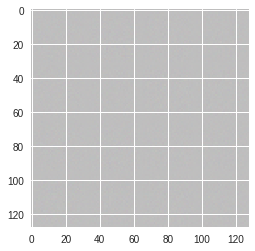

step: 12 loss_d: 0.642 loss_g: 0.011
step: 13 loss_d: 0.642 loss_g: 0.011
step: 14 loss_d: 0.638 loss_g: 0.012
step: 15 loss_d: 0.634 loss_g: 0.012
step: 16 loss_d: 0.633 loss_g: 0.013
step: 17 loss_d: 0.628 loss_g: 0.014
step: 18 loss_d: 0.626 loss_g: 0.015
step: 19 loss_d: 0.621 loss_g: 0.016
step: 20 loss_d: 0.618 loss_g: 0.017
step: 21 loss_d: 0.619 loss_g: 0.018
Reconstructed Images


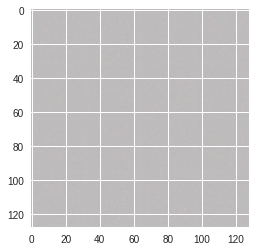

step: 22 loss_d: 0.614 loss_g: 0.019
step: 23 loss_d: 0.613 loss_g: 0.020
step: 24 loss_d: 0.607 loss_g: 0.021
step: 25 loss_d: 0.605 loss_g: 0.022
step: 26 loss_d: 0.601 loss_g: 0.024
step: 27 loss_d: 0.600 loss_g: 0.025
step: 28 loss_d: 0.593 loss_g: 0.026
step: 29 loss_d: 0.591 loss_g: 0.027
step: 30 loss_d: 0.590 loss_g: 0.029
step: 31 loss_d: 0.584 loss_g: 0.030
Reconstructed Images


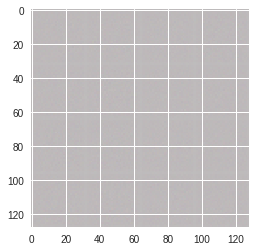

step: 32 loss_d: 0.580 loss_g: 0.032
step: 33 loss_d: 0.577 loss_g: 0.033
step: 34 loss_d: 0.574 loss_g: 0.035
step: 35 loss_d: 0.570 loss_g: 0.036
step: 36 loss_d: 0.565 loss_g: 0.038
step: 37 loss_d: 0.560 loss_g: 0.040
step: 38 loss_d: 0.559 loss_g: 0.041
step: 39 loss_d: 0.551 loss_g: 0.043
step: 40 loss_d: 0.549 loss_g: 0.045
step: 41 loss_d: 0.546 loss_g: 0.047
Reconstructed Images


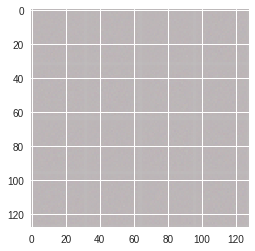

step: 42 loss_d: 0.539 loss_g: 0.049
step: 43 loss_d: 0.535 loss_g: 0.051
step: 44 loss_d: 0.532 loss_g: 0.053
step: 45 loss_d: 0.525 loss_g: 0.055
step: 46 loss_d: 0.518 loss_g: 0.057
step: 47 loss_d: 0.518 loss_g: 0.060
step: 48 loss_d: 0.508 loss_g: 0.062
step: 49 loss_d: 0.501 loss_g: 0.065
step: 50 loss_d: 0.499 loss_g: 0.067
step: 51 loss_d: 0.492 loss_g: 0.070
Reconstructed Images


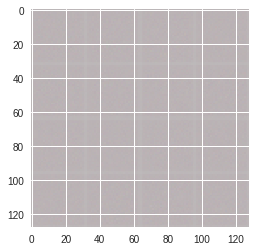

step: 52 loss_d: 0.489 loss_g: 0.072
step: 53 loss_d: 0.479 loss_g: 0.075
step: 54 loss_d: 0.477 loss_g: 0.078
step: 55 loss_d: 0.468 loss_g: 0.081
step: 56 loss_d: 0.466 loss_g: 0.084
step: 57 loss_d: 0.457 loss_g: 0.087
step: 58 loss_d: 0.453 loss_g: 0.090
step: 59 loss_d: 0.444 loss_g: 0.093
step: 60 loss_d: 0.436 loss_g: 0.096


In [0]:
# TRAIN
training_epochs = 101
k_t_ = 0
for epoch in range(training_epochs):
  # global_step_num = sess.run(global_step)

  sum_loss_d = 0.
  sum_loss_g = 0.
  
  for i in range(total_batch):
    batch_x = celebA.train.next_batch(batch_size, shuffle=True)

    noise = np.random.normal(size=(batch_size, num_hidden))

    learning_rate_ = 1e-4 * pow(0.5, epoch // 100)
    
    _, _, loss_d, loss_g, k_t_ = sess.run([train_G, train_D, loss_D, loss_G, k_tp], {
        X: batch_x, 
        Z: noise,
        learning_rate: learning_rate_,
        k_t: min(max(k_t_, 0), 1)})
    
    sum_loss_d += loss_d
    sum_loss_g += loss_g
    
  print('step: {} loss_d: {:>3.3f} loss_g: {:>3.3f}'.format(epoch + 1, sum_loss_d / total_batch, sum_loss_g / total_batch))
  if epoch > 0 and epoch % 10 == 0:
    test()